# Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Running Hive on Pyspark in Colab**

Prepare PySpark Cluster

In [2]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Define the path to your Spark archive on Google Drive
spark_archive_path = '/content/drive/MyDrive/Datasets/spark-3.0.0-bin-hadoop3.2.tgz'

# Copy the Spark archive from Google Drive to your Colab environment
!cp "$spark_archive_path" .

# Extract the Spark archive (be sure to use the correct filename)
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# Set your Spark folder to your system path environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# Install findspark using pip
!pip install -q findspark

# Run a local spark session to test your installation

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

# Installed and imported required libraries

In [4]:
import pyspark
from pyspark.sql.functions import countDistinct, col, mean
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
from pyspark.sql.functions import when

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, FMClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Load bank data to Spark Cluster

In [7]:
bh = spark.read.option("inferSchema", "true").csv('/content/drive/MyDrive/Datasets/BostonHousing.csv', header=True)

In [8]:
bh.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [9]:
print(f"Total number of observations: {bh.count()}")
print(f"Total number of variables: {len(bh.columns)}")

Total number of observations: 506
Total number of variables: 14


# Displaying top 5 rows

In [10]:
bh.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



# Combine features into a single vector column excluding 'medv' as it is a target variable

In [11]:
# Combine features into a single vector column
# feature_columns = bh.columns[:-1] # Exclude the target column 'medv'
# Assuming 'medv' is the target column
feature_columns = [col_name for col_name in bh.columns if col_name != 'medv']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
bh_feat = assembler.transform(bh).select('features')

In [12]:
bh_feat.show(5)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
+--------------------+
only showing top 5 rows



# Standardize features for principal component analysis

In [13]:
from pyspark.ml.feature import StandardScaler

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(bh_feat)
bh_stnd = scaler_model.transform(bh_feat)

In [15]:
bh_stnd.show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows



# Train model for two principal component analysis

In [16]:
from pyspark.ml.feature import PCA

# Train a model for two principal components
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(bh_stnd)
bh_pca = pca_model.transform(bh_stnd)

In [17]:
# Print explained variance ratio
print('Explained Variance Ratio:', pca_model.explainedVariance.toArray())

bh_pca.show(5)

Explained Variance Ratio: [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



# Collect distributed data in numpy array and then convert to pandas dataframe

In [19]:
#Collect distributed data in numpy array and then convert to pandas dataframe

bh_np_pca = bh_pca.rdd.map(lambda row: row.pca_features).collect()
bh_np_pca = np.array(bh_np_pca)
bh_np_pca

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [20]:
#Convert Array to DataFrame
bh_pca = pd.DataFrame(bh_np_pca,columns = ['PC1','PC2'])
bh_pca.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


# Plot two principal components

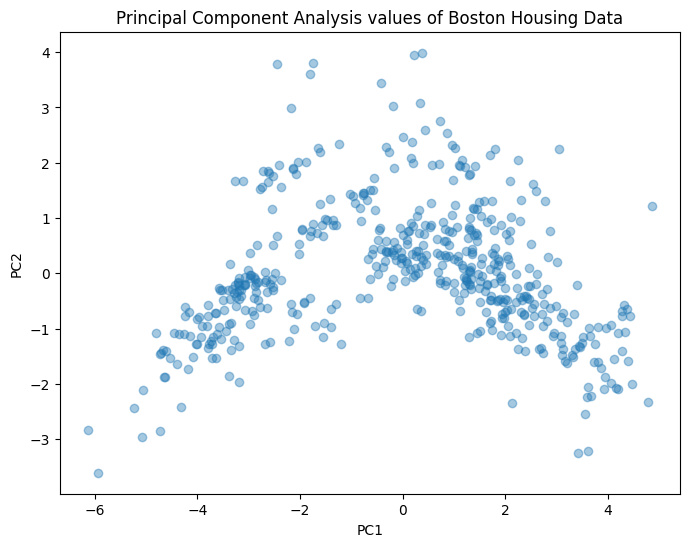

In [25]:
#Plot two principal components
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(bh_pca['PC1'], bh_pca['PC2'], alpha=0.4)
# alpha parameter is used to control the transparency or opacity of the markers (points) in the scatter plot.
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Component Analysis values of Boston Housing Data')

# Show the plot
plt.show()

# Vectorize features and target together for model development

In [26]:
#Vectorize features and target together for model development

# Use the VectorAssembler to transform your DataFrame
assembled_bh = assembler.transform(bh)

# Select the relevant columns (features and target)
assembled_bh = assembled_bh.select("features", "medv")

# Show the resulting DataFrame
assembled_bh.show()

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
|[0.22489,12.5,7.8...|15.0|
|[0.11747,12.5,7.8...|18.9|
|[0.09378,12.5,7.8...|21.7|
|[0.62976,0.0,8.14...|20.4|
|[0.63796,0.0,8.14...|18.2|
|[0.62739,0.0,8.14...|19.9|
|[1.05393,0.0,8.14...|23.1|
|[0.7842,0.0,8.14,...|17.5|
|[0.80271,0.0,8.14...|20.2|
|[0.7258,0.0,8.14,...|18.2|
+--------------------+----+
only showing top 20 rows



# Split dataset into training and testing dataset

In [34]:
#Split dataset into training and testing dataset

# The randomSplit function is used to split the assembled_bh DataFrame into two separate DataFrames: train and test,
# with a 75/25 split ratio by default. In this context, the split ratio means that approximately 75% of the data will
# go into the train DataFrame, and the remaining 25% will go into the test DataFrame.

# The seed is a random number generator seed, and setting it ensures that the same split is generated each time you
# run the code with the same seed.

train,test = assembled_bh.randomSplit([0.75,0.25], seed=88)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 366
Test Dataset Count: 140


# Fit model for linear regression

In [36]:
# Fit a linear regression model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="medv")
lr_model = lr.fit(train)

# Find out model coefficients and intercept

In [37]:
# Find model coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Model Coefficients: ", coefficients)
print("Intercept: ", intercept)

Model Coefficients:  [-0.10407530192769977,0.030488864066990105,0.06677549967557365,2.8251966835827247,-15.555855930088768,4.798093803312706,-0.005750856587675065,-1.213888926679425,0.2426319757245109,-0.010346340429426443,-1.0061379777419523,0.009668697061085843,-0.47021661333629466]
Intercept:  27.934577848298957


# Evaluate model for test dataset

In [38]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming you have a test dataset named 'test_data'
pred = lr_model.evaluate(test)

# Predcit Model
pred.predictions.show()

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.00632,18.0,2.3...|24.0|29.757657034897825|
|[0.01301,35.0,1.5...|32.7|31.086660541754867|
|[0.02009,95.0,2.6...|50.0| 42.97145067708841|
|[0.03049,55.0,3.7...|31.2|28.564340824728617|
|[0.03306,0.0,5.19...|20.6| 21.68231001505269|
|[0.0351,95.0,2.68...|48.5|41.678217158886355|
|[0.03551,25.0,4.8...|22.9| 24.34850531319431|
|[0.03659,25.0,4.8...|24.8|25.511520163974797|
|[0.03768,80.0,1.5...|34.6| 35.07866917061201|
|[0.03932,0.0,3.41...|22.0|26.836548600440548|
|[0.03961,0.0,5.19...|21.1| 20.41061607314461|
|[0.0456,0.0,13.89...|23.3| 26.58034908788906|
|[0.0459,52.5,5.32...|22.3| 26.72732869546646|
|[0.04981,21.0,5.6...|23.4| 23.92769146603171|
|[0.05083,0.0,5.19...|22.2|22.179209361657918|
|[0.05302,0.0,3.41...|28.7|30.939599416386404|
|[0.05425,0.0,4.05...|24.6|28.432685733111757|
|[0.05602,0.0,2.46...|50.0| 36.40946360984826|
|[0.05644,40.

In [48]:
from pyspark.ml.evaluation import RegressionEvaluator
#Evaluate model for test dataset

eval = RegressionEvaluator(labelCol="medv",predictionCol= "prediction", metricName= "rmse")

#RMSE
rmse = eval.evaluate(pred.predictions)
print("RMSE: %.3f" % rmse)

#MSE
mse = eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("MSE: %.3f" % mse)

#MAE
mae = eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("MAE: %.3f" % mae)

#R2
r2 = eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("R2: %.3f" % r2)

RMSE: 5.215
MSE: 27.191
MAE: 3.316
R2: 0.652


# Cross Validation and comparing RMSE value among Linear Regression, Decision Tree Regressor, Random Forest Regressor and GBTRegressor

In [47]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the regression models you want to compare
models = [
    LinearRegression(labelCol="medv", featuresCol="features"),
    DecisionTreeRegressor(labelCol="medv", featuresCol="features"),
    RandomForestRegressor(labelCol="medv", featuresCol="features"),
    GBTRegressor(labelCol="medv", featuresCol="features")  # Add GBTRegressor
]

# Define the parameter grid for each model
param_grids = {
    models[0]: ParamGridBuilder().build(),
    models[1]: ParamGridBuilder().build(),
    models[2]: ParamGridBuilder().build(),
    models[3]: ParamGridBuilder().build()  # Add parameter grid for GBTRegressor
}

# Initialize an empty list to store the results
results = []

# Loop through each model, perform cross-validation, and record results
for model in models:
    print(f"Training {model.__class__.__name__}...")

    # Create a CrossValidator with the current model
    crossval = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grids[model],
        evaluator=RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse"),
        numFolds=5
    )

    # Fit the model
    cv_model = crossval.fit(train)

    # Evaluate the model
    predictions = cv_model.transform(test)
    rmse = cv_model.avgMetrics[0]  # Get the RMSE from the cross-validation
    results.append((model.__class__.__name__, rmse))

# Display the model comparison results
for model_name, rmse in results:
    print(f"{model_name} RMSE: {rmse:.3f}")

Training LinearRegression...
Training DecisionTreeRegressor...
Training RandomForestRegressor...
Training GBTRegressor...
LinearRegression RMSE: 4.779
DecisionTreeRegressor RMSE: 4.911
RandomForestRegressor RMSE: 3.761
GBTRegressor RMSE: 4.821


In [46]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the regression models you want to compare
models = [
    LinearRegression(labelCol="medv", featuresCol="features"),
    DecisionTreeRegressor(labelCol="medv", featuresCol="features"),
    RandomForestRegressor(labelCol="medv", featuresCol="features")
]

# Define the parameter grid for each model
param_grids = {
    models[0]: ParamGridBuilder().build(),
    models[1]: ParamGridBuilder().build(),
    models[2]: ParamGridBuilder().build()
}

# Initialize an empty list to store the results
results = []

# Loop through each model, perform cross-validation, and record results
for model in models:
    print(f"Training {model.__class__.__name__}...")

    # Create a CrossValidator with the current model
    crossval = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grids[model],
        evaluator=RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse"),
        numFolds=5
    )

    # Fit the model
    cv_model = crossval.fit(train)

    # Evaluate the model
    predictions = cv_model.transform(test)
    rmse = cv_model.avgMetrics[0]  # Get the RMSE from the cross-validation
    results.append((model.__class__.__name__, rmse))

# Display the model comparison results
for model_name, rmse in results:
    print(f"{model_name} RMSE: {rmse:.3f}")


Training LinearRegression...
Training DecisionTreeRegressor...
Training RandomForestRegressor...
LinearRegression RMSE: 4.779
DecisionTreeRegressor RMSE: 4.911
RandomForestRegressor RMSE: 3.761


# Stopping Spark session

In [ ]:
spark.stop()